In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
matplotlib.style.use('seaborn-whitegrid')

In [3]:
gi = pd.read_excel('giraffe.xlsx')

In [4]:
gi_orig_size = len(gi.index)
print(f'giraffe data has {gi_orig_size} rows')

giraffe data has 1582 rows


In [5]:
gi.columns

Index(['DATE', 'DATE.1', 'IMAGE ID', 'INDIVIDUAL', 'CORRIDOR', 'CAMERA',
       'HOUR', 'SEX', 'DIRECTION', 'Direction (numerical)', 'IN', 'OUT',
       'GROUP SIZE', 'CAMERA TEMPERATURE', 'MOONPHASE', 'Passage W/O along',
       'Passage', 'COMMENT', 'MOON LUMINOSITY', 'MEAN TEMP', 'PRESSURE',
       'HUMIDITY', 'WIND SPEED', 'CLOUD COVERAGE', 'DATE.2'],
      dtype='object')

In [6]:
# drop irrelevant cols
gi = gi.drop(['IMAGE ID', 'INDIVIDUAL', 'CAMERA', 
             'CAMERA TEMPERATURE','IN', 'OUT', 'COMMENT',
              'Direction (numerical)'], axis=1)

In [7]:
# drop missing data and outlier
gi = gi[(gi.Passage != '*') & (gi.Passage != 713)]
gi = gi[gi.Passage.isnull() == False]

In [8]:
gi = gi.rename(str.lower, axis='columns')

In [9]:
gi = gi.rename(index=str, columns={
    'passage w/o along': 'passage_wo'
})

In [10]:
gi['passage'] = gi['passage'].astype(int)
gi['passage_wo'] = gi['passage_wo'].astype(int)

In [11]:
gi['passage_wo'].sum()

564

In [12]:
gi.groupby('group size')['passage_wo'].sum()

group size
0.0       0
1.0     400
2.0      91
3.0      28
4.0      14
5.0      24
6.0       6
7.0       0
8.0       0
15.0      0
Name: passage_wo, dtype: int64

In [13]:
gi[gi.sex == 'M']['passage_wo'].sum()

447

In [14]:
gi[(gi.sex == 'M') & (gi['group size'] == 1)]['passage_wo'].sum()

320

In [15]:
gi.groupby('sex')['passage_wo'].sum()

sex
F     14
M    447
U    102
Name: passage_wo, dtype: int64

In [16]:
sex_gs = gi[gi['group size'] <= 3].groupby(['sex', 'group size']).sum()['passage_wo'].reset_index()

In [17]:
sex_gs

,sex,group size,passage_wo
0,F,1.0,5
1,F,2.0,6
2,F,3.0,1
3,M,1.0,320
4,M,2.0,73
5,M,3.0,26
6,U,1.0,75
7,U,2.0,12
8,U,3.0,1


In [18]:
# females
print('std: {}'.format(np.std(sex_gs[sex_gs.sex == 'F']['passage_wo'])))
print('mean: {}'.format(np.mean(sex_gs[sex_gs.sex == 'F']['passage_wo'])))

std: 2.160246899469287
mean: 4.0


In [19]:
# females
print('std: {}'.format(np.std(sex_gs[sex_gs.sex == 'M']['passage_wo'])))
print('mean: {}'.format(np.mean(sex_gs[sex_gs.sex == 'M']['passage_wo'])))

std: 128.9504642187155
mean: 139.66666666666666


In [20]:
# unknown
print('std: {}'.format(np.std(sex_gs[sex_gs.sex == 'U']['passage_wo'])))
print('mean: {}'.format(np.mean(sex_gs[sex_gs.sex == 'U']['passage_wo'])))

std: 32.601976763516795
mean: 29.333333333333332


In [21]:
all_sex = gi.copy()

In [22]:
all_sex['sex'] = 'all'

In [23]:
all_sex = all_sex.append(gi)

In [24]:
hour_sex = all_sex.groupby(['hour', 'sex']).sum().reset_index()

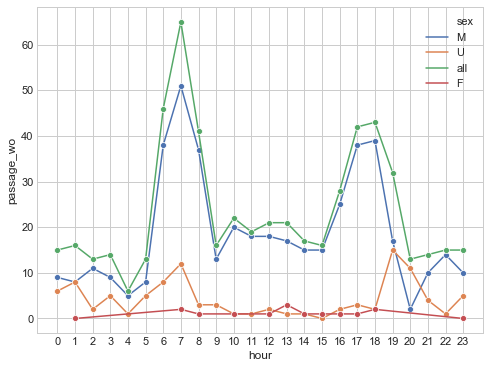

In [25]:
fig, ax = plt.subplots(1, figsize=(8,6))
sns.lineplot(x='hour', y='passage_wo', hue='sex', data=hour_sex, ax=ax, marker='o')
_=ax.set_xticks(hour_sex.hour.unique())

In [26]:
for sx in hour_sex.sex.unique():
    print('std for {}: {}'.format(sx, np.std(hour_sex[hour_sex.sex == sx]['passage_wo'])))
    print('mean for {}: {}'.format(sx, np.mean(hour_sex[hour_sex.sex == sx]['passage_wo'])))
    print('-'*35)

std for M: 12.516031386452603
mean for M: 18.625
-----------------------------------
std for U: 3.875671984744495
mean for U: 4.25
-----------------------------------
std for all: 13.88938193569302
mean for all: 23.458333333333332
-----------------------------------
std for F: 0.7993052538854533
mean for F: 1.1666666666666667
-----------------------------------


In [27]:
from scipy.stats import ttest_ind

In [58]:
early_late = gi[gi.hour.isin([6,7,8,17,18])]
rest = gi[~gi.hour.isin([6,7,8,17,18, np.nan])]

In [62]:
len(early_late.index)

277

In [63]:
len(rest.index)

435

In [60]:
ttest_ind(early_late['passage_wo'], rest['passage_wo'], equal_var=True)

Ttest_indResult(statistic=3.4183332169558733, pvalue=0.00066602527835842)

Student's t-test:
$ pvalue = 0.00067 $

In [61]:
ttest_ind(early_late['passage_wo'], rest['passage_wo'], equal_var=False)

Ttest_indResult(statistic=3.578311267587306, pvalue=0.000370781414677057)

Welch's t-test:
$ pvalue = 0.0004

In [67]:
gi.direction.unique()

array([nan, 'IN', 'OUT', 'ALONG', 'UNKNOWN'], dtype=object)

In [80]:
m_in_morning = gi[(gi.sex == 'M') & (gi.direction == 'IN') & (gi.hour.isin([6,7,8]))].groupby('hour').sum()
m_in_other = gi[(gi.sex == 'M') & (gi.direction == 'IN') & (~gi.hour.isin([6,7,8, np.nan]))].groupby('hour').sum()

In [74]:
m_in_morning

,corridor,group size,moonphase,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
hour,,,,,,,,,,,
6.0,59.0,32.0,156.0,30,30,15.7,626.0,30040.0,2090.0,92.5,1490.0
7.0,87.0,102.0,198.0,44,44,24.8,904.0,42170.0,3000.0,131.9,1820.0
8.0,45.0,27.0,119.0,22,22,11.6,450.0,22140.0,1500.0,67.9,1050.0


In [75]:
m_in_other

,corridor,group size,moonphase,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
hour,,,,,,,,,,,
0.0,6.0,3.0,14.0,3,3,2.3,66.0,3050.0,160.0,8.8,100.0
1.0,6.0,3.0,18.0,3,3,1.9,63.0,3060.0,180.0,8.8,150.0
2.0,12.0,6.0,28.0,6,6,3.4,120.0,5920.0,460.0,16.2,310.0
3.0,12.0,8.0,37.0,6,6,3.2,122.0,5740.0,430.0,17.6,280.0
4.0,10.0,9.0,34.0,5,5,2.9,105.0,5100.0,310.0,16.7,240.0
5.0,9.0,5.0,21.0,5,5,2.5,108.0,5080.0,330.0,14.8,270.0
9.0,14.0,9.0,13.0,7,7,1.7,137.0,6960.0,520.0,20.2,430.0
10.0,12.0,10.0,33.0,7,7,5.8,132.0,6760.0,510.0,18.5,350.0
11.0,12.0,12.0,22.0,6,6,2.8,116.0,5690.0,440.0,14.8,330.0


In [76]:
# student's
ttest_ind(m_in_morning['passage_wo'], m_in_other['passage_wo'], equal_var=True)

Ttest_indResult(statistic=9.114774795445223, pvalue=6.340146161295359e-09)

In [77]:
# welch's
ttest_ind(m_in_morning['passage_wo'], m_in_other['passage_wo'], equal_var=False)

Ttest_indResult(statistic=4.061470408253821, pvalue=0.05317739061870289)

In [79]:
m_out_evening = gi[(gi.sex == 'M') & (gi.direction == 'OUT') & (gi.hour.isin([16,17,18,19]))].groupby('hour').sum()
m_out_other = gi[(gi.sex == 'M') & (gi.direction == 'OUT') & (~gi.hour.isin([16,17,18,19, np.nan]))].groupby('hour').sum()

In [81]:
m_out_evening

,corridor,group size,moonphase,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
hour,,,,,,,,,,,
16.0,37.0,38.0,55.0,19,19,5.8,386.0,19200.0,1310.0,52.7,920.0
17.0,40.0,22.0,73.0,20,20,6.8,387.0,19520.0,1450.0,52.9,1160.0
18.0,62.0,42.0,168.0,32,32,14.5,642.0,31970.0,2250.0,90.7,1750.0
19.0,23.0,12.0,58.0,12,12,5.7,236.0,11680.0,860.0,32.3,610.0


In [82]:
m_out_other

,corridor,group size,moonphase,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
hour,,,,,,,,,,,
0.0,12.0,6.0,27.0,6,6,4.0,124.0,5910.0,430.0,22.1,240.0
1.0,11.0,11.0,24.0,5,5,3.9,103.0,5100.0,390.0,15.1,330.0
2.0,10.0,5.0,29.0,5,5,2.3,101.0,4980.0,330.0,11.4,260.0
3.0,6.0,3.0,22.0,3,3,1.2,62.0,3060.0,220.0,11.4,150.0
5.0,6.0,4.0,16.0,3,3,1.0,62.0,3060.0,220.0,8.8,170.0
6.0,16.0,11.0,38.0,8,8,3.4,161.0,7880.0,580.0,22.2,390.0
7.0,14.0,7.0,31.0,7,7,2.8,143.0,7100.0,480.0,22.4,330.0
8.0,30.0,28.0,55.0,15,15,6.9,307.0,14990.0,1010.0,42.0,670.0
9.0,11.0,8.0,22.0,6,6,1.9,123.0,6100.0,410.0,19.2,310.0


In [87]:
# student's
ttest_ind(m_out_evening['passage_wo'], m_in_other['passage_wo'], equal_var=True)

Ttest_indResult(statistic=6.3082325651863576, pvalue=1.9483997590623322e-06)

In [88]:
# welch's
ttest_ind(m_out_evening['passage_wo'], m_in_other['passage_wo'], equal_var=False)

Ttest_indResult(statistic=3.5655865153957476, pvalue=0.03401399090402557)

In [89]:
f_spec = gi[(gi.sex == 'F') & (gi.hour.isin([8,9,10,11,12,13]))].groupby('hour').sum()
f_other = gi[(gi.sex == 'F') & (~gi.hour.isin([8,9,10,11,12,13, np.nan]))].groupby('hour').sum()

In [92]:
# student's
ttest_ind(f_spec['passage_wo'], f_other['passage_wo'], equal_var=True)

Ttest_indResult(statistic=0.9759000729485333, pvalue=0.35213052509665566)

In [93]:
# student's
ttest_ind(f_spec['passage_wo'], f_other['passage_wo'], equal_var=False)

Ttest_indResult(statistic=0.8819171036881969, pvalue=0.4198561547261228)

In [94]:
in_dir = gi[gi.direction == 'IN'].groupby('hour').sum()['passage_wo']
out_dir = gi[gi.direction == 'OUT'].groupby('hour').sum()['passage_wo']
all_dir = gi.groupby('hour').sum()['passage_wo']

In [98]:
print('std for {}: {}'.format('IN', np.std(in_dir)))
print('mean for {}: {}'.format('IN', np.mean(in_dir)))

std for IN: 11.79681866248505
mean for IN: 11.791666666666666


In [99]:
print('std for {}: {}'.format('OUT', np.std(out_dir)))
print('mean for {}: {}'.format('OUT', np.mean(out_dir)))

std for OUT: 7.283924461137385
mean for OUT: 11.666666666666666


In [100]:
print('std for {}: {}'.format('ALL', np.std(all_dir)))
print('mean for {}: {}'.format('ALL', np.mean(all_dir)))

std for ALL: 13.88938193569302
mean for ALL: 23.458333333333332


In [105]:
# corridor 1+3 vs corridor 2 summed per-month passages
one_three = gi[gi.corridor.isin([1,3])].groupby('date.1').sum()
two = gi[gi.corridor == 2].groupby('date.1').sum()

In [106]:
one_three

,corridor,hour,group size,moonphase,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
date.1,,,,,,,,,,,,
april,3.0,20.0,1.0,1.0,0,1,0.0,21.0,1010.0,70.0,3.0,40.0
augusti,9.0,49.0,5.0,18.0,4,5,2.4,92.0,4740.0,340.0,10.7,250.0
december,19.0,91.0,37.0,35.0,0,7,1.0,153.0,7140.0,490.0,30.8,340.0
februari,3.0,23.0,1.0,6.0,1,1,1.0,23.0,1010.0,50.0,5.3,50.0
januari,7.0,15.0,3.0,11.0,2,3,0.9,65.0,3050.0,200.0,10.2,170.0
juli,26.0,137.0,32.0,30.0,7,12,4.8,221.0,12060.0,850.0,28.4,830.0
juni,12.0,107.0,12.0,27.0,5,8,5.1,160.0,7800.0,600.0,19.5,450.0
maj,14.0,163.0,50.0,67.0,4,14,4.9,283.0,14130.0,1070.0,38.1,820.0
mars,8.0,98.0,6.0,27.0,3,6,4.1,133.0,6100.0,370.0,22.6,240.0


In [107]:
two

,corridor,hour,group size,moonphase,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
date.1,,,,,,,,,,,,
april,92.0,529.0,74.0,168.0,34,46,15.4,999.0,46790.0,3380.0,149.8,2650.0
augusti,140.0,795.0,220.0,383.0,49,70,32.7,1323.0,67730.0,4960.0,175.6,3770.0
december,162.0,797.0,189.0,327.0,64,81,35.7,1706.0,82550.0,5630.0,315.2,3730.0
februari,60.0,276.0,74.0,158.0,24,30,21.1,674.0,28470.0,1810.0,111.5,990.0
januari,70.0,342.0,65.0,201.0,35,35,27.8,743.0,35520.0,2120.0,119.3,1590.0
juli,182.0,1178.0,329.0,341.0,68,91,32.5,1707.0,91780.0,6580.0,223.7,5590.0
juni,84.0,624.0,50.0,198.0,37,42,25.0,771.0,39910.0,3440.0,77.3,2700.0
maj,16.0,83.0,8.0,31.0,8,8,1.3,166.0,8160.0,580.0,20.5,410.0
mars,88.0,394.0,60.0,216.0,35,44,24.4,989.0,44690.0,2910.0,142.6,2090.0


In [108]:
# student's
ttest_ind(one_three['passage_wo'], two['passage_wo'], equal_var=True)

Ttest_indResult(statistic=-5.752764266227263, pvalue=1.0381610013750746e-05)

In [109]:
# welch's
ttest_ind(one_three['passage_wo'], two['passage_wo'], equal_var=False)

Ttest_indResult(statistic=-6.01516136548963, pvalue=7.997912080633197e-05)

In [148]:
before = gi[(gi.date < '2017-04-25') & (gi.corridor.isin([1,2]))].groupby('date').sum()
after = gi[(gi.date >= '2017-04-25') & (gi.corridor.isin([1,2]))].groupby('date').sum()

In [149]:
ttest_ind(before['passage_wo'], after['passage_wo'], equal_var=True)

Ttest_indResult(statistic=0.07803939862496231, pvalue=0.9378465772092923)

In [150]:
ttest_ind(before['passage_wo'], after['passage_wo'], equal_var=False)

Ttest_indResult(statistic=0.07837265608166159, pvalue=0.9375817232050238)

In [229]:
dark_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

In [234]:
dh = gi[gi.hour.isin(dark_hours)].groupby('moonphase').sum().reset_index()

In [235]:
print('std for {}: {}'.format('summed passages per moon phases', np.std(dh['passage_wo'])))
print('mean for {}: {}'.format('summed passages per moon phase', np.mean(dh['passage_wo'])))

std for summed passages per moon phases: 8.940777371123833
mean for summed passages per moon phase: 16.75


In [236]:
lum1 = dh[dh.moonphase.isin([1,2,8])] # IN moonphase 1,2,8
lum2 = dh[~dh.moonphase.isin([1,2,8])] # NOT IN moonphase 1,2,8

In [245]:
lum1

,moonphase,corridor,hour,group size,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
0,1.0,31.0,130.0,17.0,8,15,0.0,313.0,15210.0,1070.0,48.5,760.0
1,2.0,15.0,82.0,8.0,7,8,1.3,162.0,8150.0,600.0,24.5,490.0
7,8.0,18.0,66.0,11.0,9,9,2.5,185.0,9160.0,630.0,24.6,500.0


In [238]:
print('std for {}: {}'.format('lum1', np.std(lum1['passage_wo'])))
print('mean for {}: {}'.format('lum1', np.mean(lum1['passage_wo'])))

std for lum1: 0.816496580927726
mean for lum1: 8.0


In [246]:
lum2

,moonphase,corridor,hour,group size,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
2,3.0,73.0,661.0,62.0,34,38,20.1,814.0,37650.0,2560.0,122.9,1670.0
3,4.0,61.0,390.0,34.0,26,32,25.0,665.0,30510.0,1990.0,91.1,1110.0
4,5.0,34.0,125.0,28.0,17,18,17.7,362.0,17780.0,1210.0,62.2,780.0
5,6.0,29.0,108.0,16.0,13,14,11.6,297.0,14060.0,920.0,44.8,720.0
6,7.0,47.0,85.0,38.0,20,25,14.1,525.0,24480.0,1770.0,76.7,1190.0


In [239]:
print('std for {}: {}'.format('lum2', np.std(lum2['passage_wo'])))
print('mean for {}: {}'.format('lum2', np.mean(lum2['passage_wo'])))

std for lum2: 7.3484692283495345
mean for lum2: 22.0


In [242]:
date_sum = gi.groupby('date.1').sum()

In [244]:
date_sum

,corridor,hour,group size,moonphase,passage_wo,passage,moon luminosity,mean temp,pressure,humidity,wind speed,cloud coverage
date.1,,,,,,,,,,,,
april,95.0,549.0,75.0,169.0,34,47,50.4,2372.0,112590.0,8410.0,347.6,6650.0
augusti,149.0,844.0,225.0,401.0,53,75,71.4,2714.0,141060.0,10080.0,356.4,8010.0
december,181.0,888.0,226.0,362.0,64,88,58.6,2785.0,134480.0,9200.0,508.9,5980.0
februari,63.0,299.0,75.0,164.0,25,31,50.2,2041.0,90940.0,5600.0,366.0,3040.0
januari,77.0,357.0,68.0,212.0,37,38,62.0,2402.0,112610.0,6960.0,389.6,4480.0
juli,208.0,1315.0,361.0,371.0,75,103,68.1,2980.0,161190.0,11510.0,390.6,9930.0
juni,96.0,731.0,62.0,225.0,42,50,61.3,2188.0,113230.0,9190.0,238.6,7250.0
maj,30.0,246.0,58.0,98.0,12,22,50.0,2093.0,105300.0,8160.0,265.1,6350.0
mars,96.0,492.0,66.0,243.0,38,50,48.3,2066.0,93450.0,6130.0,319.6,4390.0


In [243]:
print('std for {}: {}'.format('passages date summed', np.std(date_sum['passage_wo'])))
print('mean for {}: {}'.format('passages date summed', np.mean(date_sum['passage_wo'])))

std for passages date summed: 22.049187437787058
mean for passages date summed: 47.0


In [ ]:
gi[gi.hour.isin(dark_hours)].groupby('moonphase').sum()

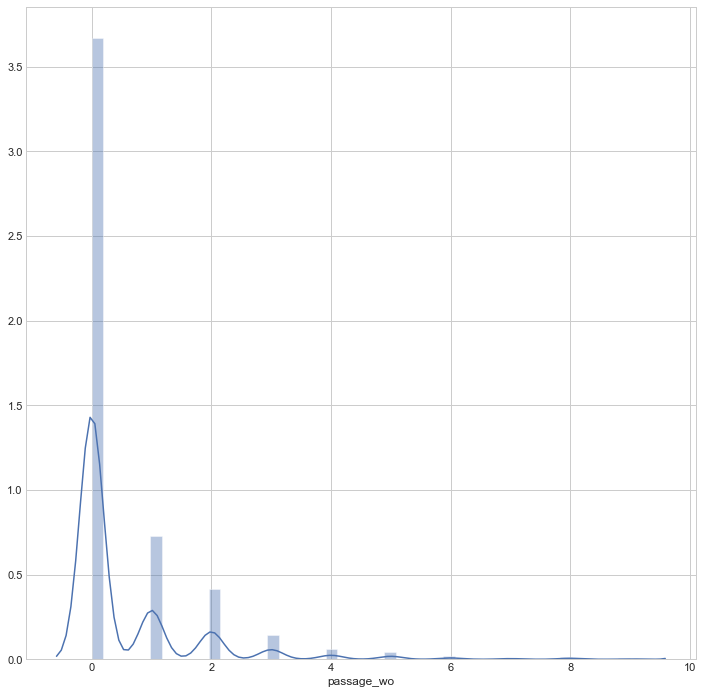

In [227]:
fig, ax = plt.subplots(1, figsize=(12,12))
sns.distplot(gi.groupby('date').sum()['passage_wo'])